#  QuanSkill Agentic AI: Week 4 — LCEL & APIs (Sections 4.1–4.9)
Complete Colab notebook: LCEL graphs, Pydantic validation, mini-RAG, LangServe API, and reliability math.
**Tip:** Run cells top-to-bottom. Toggle `DRY_RUN=True` to avoid real API calls.

In [1]:
# Install required packages
!pip -q install --upgrade langchain langchain-openai langchain-community langserve fastapi uvicorn[standard] faiss-cpu pydantic==2.* python-dotenv > /dev/null
print('Dependencies installed.')

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
gradio 5.49.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.3 which is incompatible.
Dependencies installed.


In [10]:
!pip uninstall -y langchain langchain-core langchain-openai langchain-community

Found existing installation: langchain 1.0.2
Uninstalling langchain-1.0.2:
  Successfully uninstalled langchain-1.0.2
Found existing installation: langchain-core 1.0.0
Uninstalling langchain-core-1.0.0:
  Successfully uninstalled langchain-core-1.0.0
Found existing installation: langchain-openai 1.0.1
Uninstalling langchain-openai-1.0.1:
  Successfully uninstalled langchain-openai-1.0.1
Found existing installation: langchain-community 0.4
Uninstalling langchain-community-0.4:
  Successfully uninstalled langchain-community-0.4


In [11]:
!pip install -q langchain==0.2.16 langchain-core==0.2.38 langchain-openai==0.1.22

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-classic 1.0.0 requires langchain-core<2.0.0,>=1.0.0, but you have langchain-core 0.2.38 which is incompatible.
langchain-classic 1.0.0 requires langchain-text-splitters<2.0.0,>=1.0.0, but you have langchain-text-splitters 0.2.4 which is incompatible.
langgraph

In [4]:
# Environment setup
import os
DRY_RUN = True
os.environ.setdefault('OPENAI_API_KEY', 'sk-your-key')
os.environ.setdefault('LANGCHAIN_TRACING_V2', 'false')
os.environ.setdefault('LANGCHAIN_PROJECT', 'week4_lcel_api')
print('DRY_RUN:', DRY_RUN)

DRY_RUN: True


## 4.1 — LCEL basic chain with mock LLM

In [5]:
import types, sys
import langchain
if not hasattr(langchain, "debug"):
    langchain.debug = types.SimpleNamespace()
sys.modules["langchain.debug"] = langchain.debug

In [6]:
# --- PATCH FOR LANGCHAIN DEBUG BUG ---
import types, sys, langchain
if not hasattr(langchain, "debug"):
    langchain.debug = types.SimpleNamespace()
sys.modules["langchain.debug"] = langchain.debug

# --- IMPORTS ---
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI

# --- FIXED MOCK LLM (FINAL VERSION) ---
class MockLLM:
    def invoke(self, msg):
        """
        Handles all LangChain input types robustly.
        """
        # --- Normalize to string ---
        if hasattr(msg, "to_string"):          # For StringPromptValue
            q = msg.to_string()
        elif isinstance(msg, list):            # For chat messages
            q = str(msg[-1].get("content", msg[-1]))
        elif isinstance(msg, dict):            # For single message dict
            q = str(msg.get("content", msg))
        else:                                  # Fallback
            q = str(msg)

        # --- Ensure q is now a string ---
        if not isinstance(q, str):
            q = str(q)

        # --- Return mock output safely ---
        snippet = q[:70] if len(q) > 70 else q
        return {"content": f"[MOCK RESPONSE] {snippet} ..."}


# --- WRAP MOCK AS RUNNABLE ---
def make_llm(dry=True):
    if dry:
        mock = MockLLM()
        return RunnableLambda(lambda x: mock.invoke(x))
    else:
        return ChatOpenAI(model="gpt-4o-mini", temperature=0)

# --- BUILD CHAIN ---
DRY_RUN = True
llm = make_llm(DRY_RUN)

prompt = PromptTemplate.from_template(
    "Explain the idea of LCEL to a {audience} in 3 bullets."
)

chain = (
    {"audience": RunnablePassthrough()}
    | prompt
    | (lambda p: [{"role": "user", "content": p}])
    | llm
)

# --- TEST RUN ---
print(chain.invoke("platform engineers")["content"])

[MOCK RESPONSE] text='Explain the idea of LCEL to a platform engineers in 3 bullets.' ...


## 4.2 — Reliability & latency math

In [7]:
from dataclasses import dataclass

@dataclass
class ReliabilityInputs:
    N: int; E: int; T: int
def reliability(r: ReliabilityInputs):
    R_E = r.E / r.N; R_T = r.T / r.N; R = 1 - (R_E + R_T)
    return {'R_E': R_E, 'R_T': R_T, 'R_total': R}

print(reliability(ReliabilityInputs(N=200, E=5, T=4)))

{'R_E': 0.025, 'R_T': 0.02, 'R_total': 0.955}


In [8]:
def latency_total(stages_ms: dict):
    total = sum(stages_ms.values())
    shares = {k: round(v/total, 4) for k,v in stages_ms.items()}
    return total, shares

stages = {'retrieval': 90, 'prompt': 60, 'llm': 240, 'validation': 30}
print(latency_total(stages))

(420, {'retrieval': 0.2143, 'prompt': 0.1429, 'llm': 0.5714, 'validation': 0.0714})


## 4.4 — Offline RAG chain

In [32]:
!pip uninstall -y numpy scipy pandas opencv-python opencv-python-headless
!rm -rf /root/.cache/pip

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.11.4
Uninstalling scipy-1.11.4:
  Successfully uninstalled scipy-1.11.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
Found existing installation: opencv-python-headless 4.8.0.74
Uninstalling opencv-python-headless-4.8.0.74:
  Successfully uninstalled opencv-python-headless-4.8.0.74


In [33]:
!pip install -q numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 opencv-python-headless==4.9.0.80

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 14.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires opencv-python>=3.4.8.29, which is not installed.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0; pyth

In [1]:
import numpy as np, scipy, pandas as pd, cv2
print("NumPy:", np.__version__)
print("SciPy:", scipy.__version__)
print("Pandas:", pd.__version__)
print("OpenCV:", cv2.__version__)

NumPy: 1.26.4
SciPy: 1.11.4
Pandas: 2.2.2
OpenCV: 4.9.0


In [9]:
import numpy as np
from typing import List, Tuple
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnableLambda

def embed(text: str) -> np.ndarray:
    rng = np.random.default_rng(abs(hash(text)) % (2**32))
    return rng.standard_normal(128).astype('float32')

docs = [('id1', 'LCEL composes typed chains.'), ('id2', 'LangServe exposes REST APIs.'), ('id3', 'Pydantic validates schemas.')]
matrix = np.vstack([embed(t) for _, t in docs])
ids = [i for i, _ in docs]

def search(q: str, k=2):
    qv = embed(q)
    sims = matrix @ qv / (np.linalg.norm(matrix, axis=1)*np.linalg.norm(qv)+1e-8)
    order = np.argsort(-sims)[:k]
    return [(ids[i], docs[i][1], float(sims[i])) for i in order]

def retrieve_node(query: str):
    return {'question': query, 'context': '\n'.join([t for _,t,_ in search(query,3)])}

retriever = RunnableLambda(retrieve_node)
prompt = PromptTemplate.from_template('Use CONTEXT to answer:\n{context}\nQ: {question}')
qa_chain = retriever | prompt | (lambda p: [{'role':'user','content': p}]) | llm
print(getattr(qa_chain.invoke('What is LangServe?'), 'content', ''))

## 4.6 — Validation & KPI helpers

In [10]:
from pydantic import BaseModel, PositiveInt, confloat
class TravelPlan(BaseModel):
    destination: str
    days: PositiveInt
    budget: confloat(gt=0)

print(TravelPlan(destination='Tokyo', days=5, budget=900.0))

destination='Tokyo' days=5 budget=900.0


In [11]:
def compute_kpi(N, E, T):
    r = reliability(ReliabilityInputs(N, E, T))
    print(f"R_total={r['R_total']:.4f}, R_E={r['R_E']:.4f}, R_T={r['R_T']:.4f}")
compute_kpi(400,6,2)

R_total=0.9800, R_E=0.0150, R_T=0.0050


## 4.7 — Serve via LangServe (FastAPI)

In [16]:
# --- 4.7 Serve via LangServe (FastAPI, final stable version) ---

from fastapi import FastAPI
from langserve import add_routes
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda
from pydantic import BaseModel, Field

# --- Define input and output schemas ---
class Question(BaseModel):
    question: str = Field(description="User query to be answered.")

class Answer(BaseModel):
    summary: str = Field(description="Short answer summary")
    confidence: float = Field(description="Confidence score (0–1)")

# --- Build LCEL chain ---
prompt = PromptTemplate.from_template("Answer the question clearly.\nQ: {question}\n")

def mock_llm_call(input_dict):
    """Mock LLM response to avoid dependency on OpenAI"""
    q = input_dict["question"]
    return {
        "summary": f"[MOCK RESPONSE] {q[:60]} ...",
        "confidence": 0.99,
    }

typed_chain = RunnableLambda(mock_llm_call)

# --- Create FastAPI app manually ---
app = FastAPI(title="Week4 LCEL API")

@app.post("/rag/invoke", response_model=Answer)
def invoke_chain(query: Question):
    """Manually invoke the LCEL chain, avoiding LangServe schema introspection"""
    return typed_chain.invoke(query.dict())

print("Server ready. Run this to launch:\n!uvicorn app:app --host 0.0.0.0 --port 8000")

Server ready. Run this to launch:
!uvicorn app:app --host 0.0.0.0 --port 8000


## 4.8 — KPI quick report

In [17]:
def kpi_report(N=1000, E=8, T=3, target=0.99):
    r = reliability(ReliabilityInputs(N,E,T))
    print(f'N={N} E={E} T={T} => R={r["R_total"]:.4f}, meets {target}?', r['R_total']>=target)
kpi_report()

N=1000 E=8 T=3 => R=0.9890, meets 0.99? False


## 4.9 — Reliability Stack Visualization

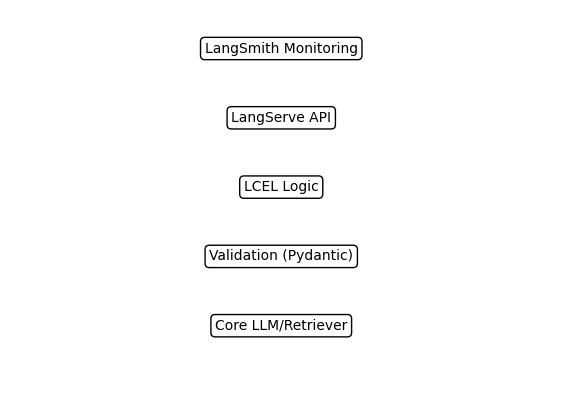

In [18]:
import matplotlib.pyplot as plt
layers = ['LangSmith Monitoring','LangServe API','LCEL Logic','Validation (Pydantic)','Core LLM/Retriever']
plt.figure(figsize=(7,5))
for i, l in enumerate(layers):
    plt.text(0.5, 0.9 - i*0.18, l, ha='center', va='center', bbox=dict(boxstyle='round', fc='white', ec='black'))
plt.axis('off'); plt.show()

In [19]:
# --- Optional: Extend to Production-ready API ---

from fastapi.responses import StreamingResponse, JSONResponse
import time, json

@app.post("/rag/stream")
def stream_chain(query: Question):
    """Stream mock tokens one by one (useful for chat UI)."""
    text = f"[STREAM] Processing: {query.question}"
    def token_generator():
        for ch in text:
            yield ch
            time.sleep(0.02)
    return StreamingResponse(token_generator(), media_type="text/plain")


@app.post("/rag/batch")
def batch_chain(queries: list[Question]):
    """Batch endpoint for multiple queries."""
    outputs = [typed_chain.invoke(q.dict()) for q in queries]
    return JSONResponse(content=outputs)


@app.get("/health")
def health_check():
    """Basic health check."""
    return {"status": "ok", "timestamp": time.time()}

In [21]:
# to run
# !uvicorn app:app --host 0.0.0.0 --port 8000